In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os,re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# performance check
import time

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# torch
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from collections import defaultdict

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab\ Notebooks/MBTI 2'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MBTI 2


In [ ]:
# variable
MAX_LEN = 512
EPOCHS = 10
THRESHOLD = 0.5
BATCH_SIZE = 16
RANDOM_SEED = 42
TEST_SIZE = 0.05
LR = 3e-5

In [ ]:
# reading the dataset
data=pd.read_csv('mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


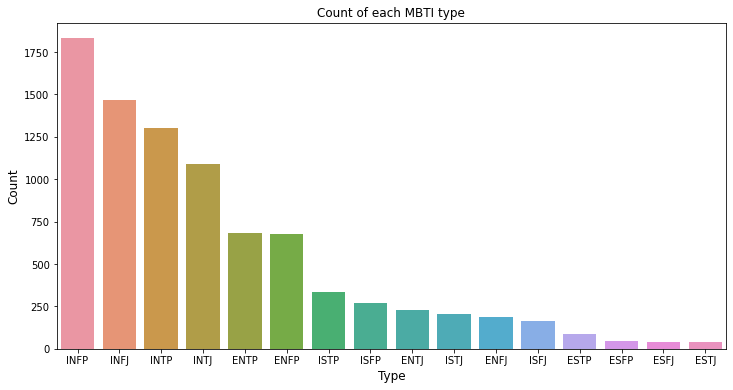

In [ ]:
# data分布
print(data["type"].value_counts())
# dict[MBTI_type] = count
dic = dict(data["type"].value_counts())
# plotting number of types and their counts
g = sns.barplot([key for key in dic], [dic[key] for key in dic])
plt.title('Count of each MBTI type')
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
g.figure.set_size_inches(12,6)
plt.show()

In [ ]:
def clean_text(posts):
  clean = []
  # lower case
  posts = posts.lower()
  # remove emali
  posts = re.sub(re.compile(r'\S+@\S+'), "", posts)
  # remove tag
  posts = re.sub(re.compile(r'@\S+'), "", posts)
  # remove '
  posts = re.sub(re.compile(r'\''), "", posts)
  # posts(|||)->list
  posts = posts.split('|||')
  # removing links and use len(posts) > 5
  posts = [s for s in posts if not re.search(r'https?:\/\/[^\s<>"]+|www\.[^\s<>"]+', s) if len(s)>5]

  return ' '.join(posts) 

In [ ]:
# to handle the class imbalance better, converting the 16 classes into 4 more balanced classes
data["is_Extrovert"] = data["type"].apply(lambda x: 1 if x[0] == "E" else 0)
data["is_Sensing"] = data["type"].apply(lambda x: 1 if x[1] == "S" else 0)
data["is_Thinking"] = data["type"].apply(lambda x: 1 if x[2] == "T" else 0)
data["is_Judging"] = data["type"].apply(lambda x: 1 if x[3] == "J" else 0)
# to clean posts
data['clean_posts'] = data['posts'].apply(lambda x: clean_text(x))
data = data[["type", "is_Extrovert", "is_Sensing", "is_Thinking", "is_Judging", "posts", 'clean_posts']]
data.head()

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,what has been the most life-changing experienc...
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,"of course, to which i say i know; thats my ble..."
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...","dear intp, i enjoyed our conversation the ot..."
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconception...


In [ ]:
# label_cols(list) = ['is_Extrovert', 'is_Sensing', 'is_Thinking', 'is_Judging'] 存取欄位名稱
cols = data.columns
label_cols = list(cols[1:5])
label_cols

['is_Extrovert', 'is_Sensing', 'is_Thinking', 'is_Judging']

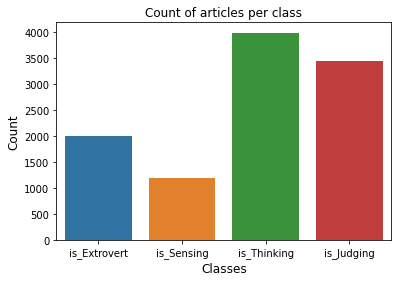

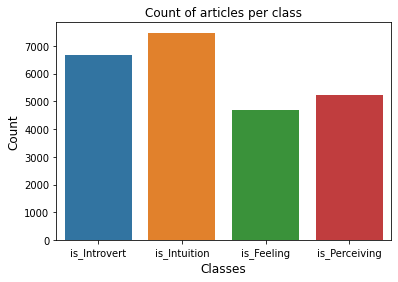

In [ ]:
# balance data後分布
# plotting number of E, S, T, J and their count of articles
sns.barplot(label_cols, data.iloc[:,1:5].sum().values)
plt.title('Count of articles per class')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# plotting number of I, N, F, P and their count of articles
sns.barplot(['is_Introvert', 'is_Intuition', 'is_Feeling', 'is_Perceiving'], data.shape[0]-data.iloc[:,1:5].sum().values)
plt.title('Count of articles per class')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [ ]:
# one hot labels
data['one_hot_labels'] = list(data[label_cols].values)
labels = list(data['one_hot_labels'].values)
clean_posts = list(data['clean_posts'].values)

print(labels[0]) # INFJ --> [0 0 0 1] 
print(clean_posts[0]) # what has been the most life-changing experience in your life?
data.head()

[0 0 0 1]
what has been the most life-changing experience in your life? may the perc experience immerse you. hello enfj7. sorry to hear of your distress. its only natural for a relationship to not be perfection all the time in every moment of existence. try to figure the hard times as times of growth, as... welcome and stuff. prozac, wellbrutin, at least thirty minutes of moving your legs (and i dont mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative... basically come up with three items youve determined that each type (or whichever types you want to do) would more than likely use, given each types cognitive functions and whatnot, when left by... all things in moderation.  sims is indeed a video game, and a good one at that. note: a good one at that is somewhat subjective in that i am not completely promoting the death of any given sim... dear enfp:  what were your favorite video games growing up and what are your n

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,one_hot_labels
0,INFJ,0,0,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,what has been the most life-changing experienc...,"[0, 0, 0, 1]"
1,ENTP,1,0,1,0,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[1, 0, 1, 0]"
2,INTP,0,0,1,0,'Good one _____ https://www.youtube.com/wat...,"of course, to which i say i know; thats my ble...","[0, 0, 1, 0]"
3,INTJ,0,0,1,1,"'Dear INTP, I enjoyed our conversation the o...","dear intp, i enjoyed our conversation the ot...","[0, 0, 1, 1]"
4,ENTJ,1,0,1,1,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconception...,"[1, 0, 1, 1]"


In [ ]:
class MBTIDataset(TensorDataset):

  def __init__(self, clean_posts, one_hot_labels, tokenizer, max_len):
    self.clean_posts = clean_posts
    self.one_hot_labels = one_hot_labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.clean_posts)
  
  def __getitem__(self, index):
    clean_post = self.clean_posts[index]
    one_hot_label = self.one_hot_labels[index]

    encoding = self.tokenizer.encode_plus(
      clean_post,
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True,
      pad_to_max_length=True,
      return_tensors='pt',
    )

    return {
      'clean_posts': clean_posts,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'one_hot_label': torch.tensor(one_hot_label)
    }


In [ ]:
data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify= data['type'])

In [ ]:
print(len(data_train))
print(data_train["type"].value_counts())
print(len(data_val))
print(data_val["type"].value_counts())

8241
INFP    1740
INFJ    1396
INTP    1239
INTJ    1036
ENTP     651
ENFP     641
ISTP     320
ISFP     257
ENTJ     219
ISTJ     195
ENFJ     181
ISFJ     158
ESTP      85
ESFP      46
ESFJ      40
ESTJ      37
Name: type, dtype: int64
434
INFP    92
INFJ    74
INTP    65
INTJ    55
ENFP    34
ENTP    34
ISTP    17
ISFP    14
ENTJ    12
ISTJ    10
ENFJ     9
ISFJ     8
ESTP     4
ESFJ     2
ESTJ     2
ESFP     2
Name: type, dtype: int64


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MBTIDataset(
    clean_posts=df['clean_posts'].to_numpy(),
    one_hot_labels=df['one_hot_labels'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  sampler = RandomSampler(ds)

  return DataLoader(
    ds,
    sampler=sampler,
    batch_size=batch_size,
  )

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_dataloader = create_data_loader(data_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_data_loader(data_val, tokenizer, MAX_LEN, BATCH_SIZE)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
data_next = next(iter(train_dataloader))
data_next.keys()

dict_keys(['clean_posts', 'input_ids', 'attention_mask', 'one_hot_label'])

In [ ]:
print(data_next['input_ids'])
print(data_next['attention_mask'])
print(data_next['one_hot_label'])

tensor([[  101,  3087,  2182,  ...,  2049,  3294,   102],
        [  101,  4283,  1012,  ...,  3802, 16066,   102],
        [  101,  1045,  2079,  ...,  1999,  1996,   102],
        ...,
        [  101,  8886,  1024,  ...,  2061,  2052,   102],
        [  101,  2092,  1010,  ...,  8266,  1999,   102],
        [  101,  1996,  2111,  ...,  2172,  3618,   102]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([[1, 0, 1, 1],
        [0, 0, 0, 1],
        [1, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 1, 0],
        [0, 1, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 1, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0]])


In [ ]:
# loading pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
data_next['input_ids'].shape # batch size x seq length

torch.Size([16, 512])

In [ ]:
# enabling GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),lr=LR,correct_bias=True)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = BCEWithLogitsLoss()


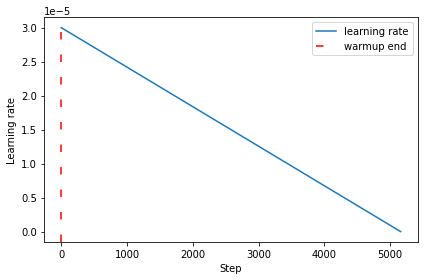

In [ ]:
learning_rate_history = []
warmup_steps = 0
for step in range(total_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

In [ ]:
# device name of GPU
device = 'cuda'
torch.cuda.get_device_name(0)

'A100-SXM4-40GB'

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()
  losses = []
  true_labels, pred_labels = [],[]
  
  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    label = d['one_hot_label'].to(device)

    # forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    pred_label = torch.sigmoid(logits)
    
    # converting logits and labels to appropriate shape 
    loss = loss_fn(logits.view(-1,4), label.type_as(logits).view(-1,4)) 
    losses.append(loss.item())

    # converting tensors to numpy arrays
    pred_label = pred_label.detach().cpu()
    label = label.detach().cpu()

    true_labels.append(label.numpy())
    pred_labels.append(pred_label.numpy())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  # flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  # calculate accuracy
  threshold = 0.5
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]

  train_acc = accuracy_score(true_bools,pred_bools)
  train_f1 = f1_score(true_bools,pred_bools,average='micro')
  return train_acc, train_f1, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()
  losses = []
  logit_preds, true_labels, pred_labels = [],[],[]
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      label = d['one_hot_label'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs[0]
      pred_label = torch.sigmoid(logits)

      # converting logits and labels to appropriate shape 
      loss = loss_fn(logits.view(-1,4), label.type_as(logits).view(-1,4)) 
      losses.append(loss.item())

      # converting tensors to numpy arrays
      pred_label = pred_label.detach().cpu().numpy()
      label = label.detach().cpu().numpy()

      true_labels.append(label)
      pred_labels.append(pred_label)

  # flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]
  # calculate accuracy
  threshold = 0.5
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  
  # F1 = 2 * (precision * recall) / (precision + recall)
  val_f1 = f1_score(true_bools,pred_bools,average='micro')
  val_acc = accuracy_score(true_bools,pred_bools)
      
  return val_acc, val_f1, np.mean(losses), pred_bools, true_bools

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_f1, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler)
  print(f'Train loss: {train_loss}  accuracy: {train_acc}  f1: {train_f1}')

  val_acc, val_f1, val_loss, val_pred_bools, val_true_bools = eval_model(model, val_dataloader, loss_fn, device)
  print(f'Val   loss {val_loss} accuracy {val_acc}  f1: {val_f1}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_f1'].append(train_f1)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_f1'].append(train_f1)

  if val_acc > best_accuracy:
    # Save model
    torch.save(model.state_dict(), 'model_state_dict0114.pt')
    torch.save(model, 'model0114.pt')
    best_accuracy = val_acc


Epoch 1/10
----------
Train loss: 0.4863658693236436  accuracy: 0.3936415483557821  f1: 0.5456643186786495
Val   loss 0.3825466441256659 accuracy 0.576036866359447  f1: 0.6872928176795581

Epoch 2/10
----------
Train loss: 0.35642249662746756  accuracy: 0.600412571289892  f1: 0.7391141742800663
Val   loss 0.33993550948798656 accuracy 0.6036866359447005  f1: 0.7366336633663367

Epoch 3/10
----------
Train loss: 0.28474004417946636  accuracy: 0.6825627957772115  f1: 0.8061683220073184
Val   loss 0.38215296662279535 accuracy 0.5990783410138248  f1: 0.7199170124481328

Epoch 4/10
----------
Train loss: 0.22000292348567135  accuracy: 0.748452857662905  f1: 0.8599629858112277
Val   loss 0.3877661382513387 accuracy 0.6082949308755761  f1: 0.7373637264618434

Epoch 5/10
----------
Train loss: 0.16586055312045786  accuracy: 0.817376531974275  f1: 0.9044032152065113
Val   loss 0.44931439044220106 accuracy 0.6221198156682027  f1: 0.7477386934673368

Epoch 6/10
----------
Train loss: 0.11903704197

10


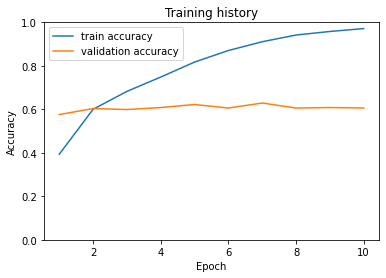

In [ ]:
# Training & Validation acc loss
print(len(history['train_acc']))
plt.plot([i+1 for i in range(EPOCHS)],history['train_acc'] , label='train accuracy')
plt.plot([i+1 for i in range(EPOCHS)], history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);



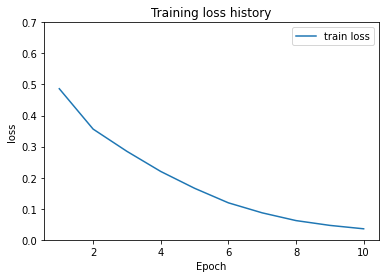

In [ ]:
plt.plot([i+1 for i in range(EPOCHS)], history['train_loss'], label='train loss')
plt.title('Training loss history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.7]);

In [ ]:
# turn bool_lst into mbti type
def bool_to_mbti(bool_lst):
  mbti_lst = []
  for b in bool_lst:
    mbti = ''
    for i in range(len(b)):
      if i == 0:
        mbti += 'E' if b[i] else 'I'
      if i == 1:
        mbti += 'S' if b[i] else 'N'
      if i == 2:
        mbti += 'T' if b[i] else 'F'
      if i == 3:
        mbti += 'J' if b[i] else 'P'
    mbti_lst.append(mbti)
  return mbti_lst

              precision    recall  f1-score   support

        INFJ       0.56      0.45      0.50        11
        ENTP       0.65      0.67      0.66        33
        INTP       0.42      0.56      0.48         9
        INTJ       0.59      0.62      0.61        32
        ENTJ       0.50      0.33      0.40         3
        ENFJ       0.50      0.33      0.40         3
        INFP       0.50      0.50      0.50         2
        ENFP       0.75      0.60      0.67         5
        ISFP       0.57      0.56      0.56        75
        ISTP       0.70      0.63      0.66       102
        ISFJ       0.58      0.64      0.61        50
        ISTJ       0.71      0.61      0.65        76
        ESTP       0.50      0.67      0.57         6
        ESFP       0.36      0.38      0.37        13
        ESTJ       0.30      0.75      0.43         4
        ESFJ       0.53      0.90      0.67        10

    accuracy                           0.61       434
   macro avg       0.54   

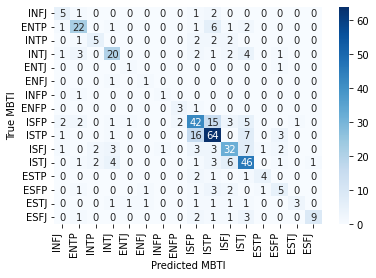

In [ ]:
pred_mbti = bool_to_mbti(val_pred_bools)
true_mbti = bool_to_mbti(val_true_bools)
possible_labels = data['type'].unique()
print(classification_report(pred_mbti, true_mbti, target_names=possible_labels))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=90, ha='right')
  plt.ylabel('True MBTI')
  plt.xlabel('Predicted MBTI');

cm = confusion_matrix(true_mbti, pred_mbti)
df_cm = pd.DataFrame(cm, index=possible_labels, columns=possible_labels)
show_confusion_matrix(df_cm)